# Extra que tive que fazer pra rodar com o CSV (da pra esconder essa parte)

In [1]:
# Preliminares do colab
!pip install chess

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.5/156.5 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for chess: filename=chess-1.11.1-py3-none-any.whl size=148497 sha256=3f045c9f88bd2c45e1a4d0439530166c10ed9a2e2deeab9d914b5cce26060d28
  Stored in directory: /root/.cache/pip/wheels/2e/2d/23/1bfc95db984ed3ecbf6764167dc7526d0ab521cf9a9852544e
Successfully built chess


In [ ]:
import pandas as pd
import numpy as np

# Specify the path to your CSV file
file_path = 'content/board-eval-unique-lichess_db_standard_rated_2013-01.csv'  # Replace with your actual file path

# Load the CSV file
data = pd.read_csv(file_path)

# Extract the board states (first 768 columns) and evaluations (last column)
board_states = data.iloc[:, :-1].values  # Shape: (n, 768)
evaluations = data.iloc[:, -1].values   # Shape: (n,)

# Reshape the board states to (n, 8, 8, 12)
n = board_states.shape[0]  # Number of samples
reshaped_board_states = board_states.reshape(n, 8, 8, 12).astype(int)  # New shape: (n, 8, 8, 12)

# Save the features (X) and labels (y) as .npy files
np.save('board_states.npy', reshaped_board_states)
np.save('evaluations.npy', evaluations)

# PGN to Tensor

In [3]:
import chess
import chess.pgn
import numpy as np

In [4]:
def create_board_tensor(board):
    # Initialize 8x8x12 tensor with zeros
    tensor = np.zeros((8, 8, 12), dtype=np.float32)

    # Piece type mapping (6 pieces * 2 colors = 12 channels)
    piece_idx = {
        'P': 0, 'N': 1, 'B': 2, 'R': 3, 'Q': 4, 'K': 5,
        'p': 6, 'n': 7, 'b': 8, 'r': 9, 'q': 10, 'k': 11
    }

    # Fill tensor based on piece positions
    for square in chess.SQUARES:
        piece = board.piece_at(square)
        if piece is not None:
            rank = 7 - chess.square_rank(square)  # Flip rank for correct orientation
            file = chess.square_file(square)
            tensor[rank, file, piece_idx[piece.symbol()]] = 1

    return tensor

In [5]:
def extract_eval(comment):
    if not comment or '[%eval' not in comment:
        return None

    try:
        # Extract everything between [%eval and ]
        start = comment.index('[%eval') + 6
        end = comment.index(']', start)
        eval_str = comment[start:end].strip()

        # Handle mate scores
        if eval_str.startswith('#'):
            return 100 if int(eval_str[1:]) > 0 else -100

        # Handle regular scores
        return float(eval_str)
    except:
        return None

In [6]:
def process_pgn(pgn_file, max_positions):
    positions = {}  # Dictionary to store unique positions and their evaluations

    with open(pgn_file) as f:
        while True:
            game = chess.pgn.read_game(f)
            if game is None:
                break

            board = game.board()
            node = game

            while node.variations:
                node = node.variation(0)
                board.push(node.move)

                eval_score = extract_eval(node.comment)
                if eval_score is not None:
                    # Create FEN string without move counters to identify unique positions
                    fen = board.fen().rsplit(' ', 2)[0]
                    if fen not in positions:
                        tensor = create_board_tensor(board)
                        positions[fen] = (tensor, eval_score)

                        # Stop if max_positions is reached
                        if len(positions) >= max_positions:
                            print(f"Reached max positions limit: {max_positions}")
                            return positions

    return positions

## Rodar o código

In [ ]:
# Usage
pgn_file = "filtered_games_2016_12.pgn"
max_positions = 50000  # Limit the number of board states stored
positions = process_pgn(pgn_file, max_positions)

# Convert to training data
X = []  # Tensors
y = []  # Evaluations

for tensor, eval_score in positions.values():
    X.append(tensor)
    y.append(eval_score)

X = np.array(X)
y = np.array(y)

# Now X and y are ready for machine learning
# X.shape should be (n_positions, 8, 8, 12)
# y.shape should be (n_positions,)

print(f"Total unique positions: {len(positions)}")
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

# Save
np.save('processed_data/board_states.npy', X)
np.save('processed_data/evaluations.npy', y)

Reached max positions limit: 50000
Total unique positions: 50000
X shape: (50000, 8, 8, 12)
y shape: (50000,)


# CNN

In [7]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Load the preprocessed data (optional if X and y are already loaded)
X = np.load('board_states.npy')
y = np.load('evaluations.npy')

# Split the data into training and validation sets
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

Num GPUs Available:  0


FileNotFoundError: [Errno 2] No such file or directory: 'board_states.npy'

In [4]:
# 3. Create tf.data.Dataset pipelines
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

# Training dataset
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(buffer_size=10000)
train_dataset = train_dataset.batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(AUTOTUNE)

# Validation dataset
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_dataset = val_dataset.cache()
val_dataset = val_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.prefetch(AUTOTUNE)

In [5]:
def create_chess_cnn():
    model = models.Sequential([
        layers.Input(shape=(8, 8, 12)),

        # First convolutional block
        layers.Conv2D(64, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.ReLU(),

        # Second convolutional block
        layers.Conv2D(128, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.ReLU(),

        # Third convolutional block
        layers.Conv2D(256, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.ReLU(),

        # Fourth convolutional block
        layers.Conv2D(512, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.ReLU(),

        # Flatten and dense layers
        layers.Flatten(),
        layers.Dense(1024, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.3),

        # Output layer with linear activation
        layers.Dense(1, activation='linear')
    ])

    return model

## Rodar a CNN

In [6]:
# Create and compile the model
model = create_chess_cnn()
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='mse',  # Mean squared error for regression
    metrics=['mae']  # Mean absolute error
)

# Print model summary
model.summary()

# Training callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-6
    ),
    tf.keras.callbacks.ModelCheckpoint(
        'chess_evaluation_model.keras',
        monitor='val_loss',
        save_best_only=True
    )
]

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 8, 8, 64)            │           6,976 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 8, 8, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu (ReLU)                         │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_1 (ReLU)                       │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 8, 8, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 8, 8, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_2 (ReLU)                       │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 8, 8, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 8, 8, 512)           │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_3 (ReLU)                       │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │      33,555,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 35,640,769 (135.96 MB)

 Trainable params: 35,638,849 (135.95 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [7]:
# Train the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50,
    callbacks=callbacks
)

# Save the model
model.save('chess_evaluation_model.keras')

Epoch 1/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 31s 17ms/step - loss: 776.4574 - mae: 13.7526 - val_loss: 441.9875 - val_mae: 10.7029 - learning_rate: 0.0010
Epoch 2/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - loss: 414.9401 - mae: 9.3353 - val_loss: 347.8382 - val_mae: 8.5341 - learning_rate: 0.0010
Epoch 3/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - loss: 348.1786 - mae: 8.5711 - val_loss: 475.6866 - val_mae: 12.3524 - learning_rate: 0.0010
Epoch 4/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - loss: 300.6295 - mae: 7.9321 - val_loss: 370.5463 - val_mae: 9.0218 - learning_rate: 0.0010
Epoch 5/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - loss: 274.7351 - mae: 7.5412 - val_loss: 384.9666 - val_mae: 8.4664 - learning_rate: 0.0010
Epoch 6/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 24s 20ms/step - loss: 211.6055 - mae: 6.6412 - val_loss: 307.3763 - val_mae: 7.7796 - learning_rate: 5.0000e-04
Epoch 7/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 41s 20ms/step - loss: 183.1643 - mae: 6.2287 - val_

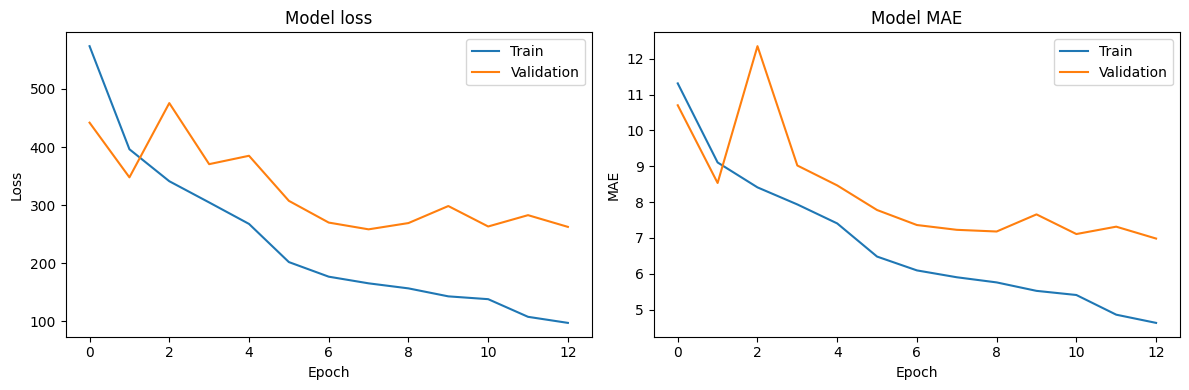

In [8]:
# Plot training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# Plot training & validation loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

# Plot training & validation mean absolute error
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Model MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()

# Chess Bot

In [10]:
import chess
import numpy as np
import tensorflow as tf

# Load the trained model
model = tf.keras.models.load_model('epoch19-chess_evaluation_model.keras')

def create_board_tensor(board):
    # Initialize 8x8x12 tensor with zeros
    tensor = np.zeros((8, 8, 12), dtype=np.float32)

    # Piece type mapping (6 pieces * 2 colors = 12 channels)
    piece_idx = {
        'P': 0, 'N': 1, 'B': 2, 'R': 3, 'Q': 4, 'K': 5,
        'p': 6, 'n': 7, 'b': 8, 'r': 9, 'q': 10, 'k': 11
    }

    # Fill tensor based on piece positions
    for square in chess.SQUARES:
        piece = board.piece_at(square)
        if piece is not None:
            rank = 7 - chess.square_rank(square)  # Flip rank for correct orientation
            file = chess.square_file(square)
            tensor[rank, file, piece_idx[piece.symbol()]] = 1

    return tensor

def evaluate_position(board):
    tensor = create_board_tensor(board)
    tensor = np.expand_dims(tensor, axis=0)  # Add batch dimension
    evaluation = model.predict(tensor)
    return evaluation[0][0]

def get_best_move(board):
    legal_moves = list(board.legal_moves)
    best_move = None
    best_eval = -float('inf')  # Initialize to a very low value

    for move in legal_moves:
        board.push(move)  # Apply the move temporarily
        eval_score = evaluate_position(board)  # Evaluate the position after the move
        if eval_score > best_eval:
            best_eval = eval_score
            best_move = move
        board.pop()  # Undo the move

    return best_move

def play_chess_game():
    board = chess.Board()
    while not board.is_game_over():
        print(board)

        # Bot's turn (AI Move)
        print("Bot's Move:")
        move = get_best_move(board)  # Get the best move for the current position
        print(f"Bot plays: {move}")
        board.push(move)  # Apply the bot's move

        # Check if game is over after bot's move
        if board.is_game_over():
            print("Game over!")
            print(board)
            break

        # Your turn (Human Move)
        print("\nYour turn:")
        human_move = input("Enter your move (e.g., e2e4): ").strip()

        try:
            move = chess.Move.from_uci(human_move)
            if move in board.legal_moves:
                board.push(move)  # Apply the human's move
            else:
                print("Invalid move! Try again.")
        except:
            print("Invalid move format! Please try again.")

# Play a game
play_chess_game()

TypeError: <class 'keras.src.models.sequential.Sequential'> could not be deserialized properly. Please ensure that components that are Python object instances (layers, models, etc.) returned by `get_config()` are explicitly deserialized in the model's `from_config()` method.

config={'module': 'keras', 'class_name': 'Sequential', 'config': {'name': 'sequential_1', 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_input_shape': [None, 8, 8, 12], 'dtype': 'float32', 'sparse': False, 'ragged': False, 'name': 'input_2'}, 'registered_name': None}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_4', 'trainable': True, 'dtype': 'float32', 'filters': 64, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 8, 8, 12]}}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_4', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 8, 8, 64]}}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 're_lu_4', 'trainable': True, 'dtype': 'float32', 'max_value': None, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 8, 8, 64]}}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_5', 'trainable': True, 'dtype': 'float32', 'filters': 128, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 8, 8, 64]}}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_5', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 8, 8, 128]}}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 're_lu_5', 'trainable': True, 'dtype': 'float32', 'max_value': None, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 8, 8, 128]}}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_6', 'trainable': True, 'dtype': 'float32', 'filters': 256, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 8, 8, 128]}}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_6', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 8, 8, 256]}}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 're_lu_6', 'trainable': True, 'dtype': 'float32', 'max_value': None, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 8, 8, 256]}}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_7', 'trainable': True, 'dtype': 'float32', 'filters': 512, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 8, 8, 256]}}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_7', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 8, 8, 512]}}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 're_lu_7', 'trainable': True, 'dtype': 'float32', 'max_value': None, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 8, 8, 512]}}, {'module': 'keras.layers', 'class_name': 'Flatten', 'config': {'name': 'flatten_1', 'trainable': True, 'dtype': 'float32', 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 8, 8, 512]}}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'dense_3', 'trainable': True, 'dtype': 'float32', 'units': 1024, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 32768]}}, {'module': 'keras.layers', 'class_name': 'Dropout', 'config': {'name': 'dropout_2', 'trainable': True, 'dtype': 'float32', 'rate': 0.3, 'noise_shape': None, 'seed': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 1024]}}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'dense_4', 'trainable': True, 'dtype': 'float32', 'units': 512, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 1024]}}, {'module': 'keras.layers', 'class_name': 'Dropout', 'config': {'name': 'dropout_3', 'trainable': True, 'dtype': 'float32', 'rate': 0.3, 'noise_shape': None, 'seed': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 512]}}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'dense_5', 'trainable': True, 'dtype': 'float32', 'units': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 512]}}]}, 'registered_name': None, 'build_config': {'input_shape': [None, 8, 8, 12]}, 'compile_config': {'optimizer': {'module': 'keras.optimizers', 'class_name': 'Adam', 'config': {'name': 'Adam', 'weight_decay': None, 'clipnorm': None, 'global_clipnorm': None, 'clipvalue': None, 'use_ema': False, 'ema_momentum': 0.99, 'ema_overwrite_frequency': None, 'jit_compile': True, 'is_legacy_optimizer': False, 'learning_rate': 0.0010000000474974513, 'beta_1': 0.9, 'beta_2': 0.999, 'epsilon': 1e-07, 'amsgrad': False}, 'registered_name': None}, 'loss': 'mse', 'metrics': ['mae'], 'loss_weights': None, 'weighted_metrics': None, 'run_eagerly': None, 'steps_per_execution': None, 'jit_compile': None}}.

Exception encountered: <class 'keras.src.layers.normalization.batch_normalization.BatchNormalization'> could not be deserialized properly. Please ensure that components that are Python object instances (layers, models, etc.) returned by `get_config()` are explicitly deserialized in the model's `from_config()` method.

config={'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_4', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 8, 8, 64]}}.

Exception encountered: Error when deserializing class 'BatchNormalization' using config={'name': 'batch_normalization_4', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}.

Exception encountered: int() argument must be a string, a bytes-like object or a real number, not 'list'